<a href="https://colab.research.google.com/github/obarnstedt/LINdoscope2023/blob/main/notebooks/CEBRA_LINdoscope2023_1Pdemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 👋  Welcome to the CEBRA demo!


Adapted from https://github.com/stes/Nx-435_EPFL (Anastasiia Filippova & Mackenzie Mathis, viz by Oliver Barnstedt)

In [48]:
import cebra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cebra.integrations.matplotlib as cebra_plot
from cebra import CEBRA

### Data loading

In [9]:
from week5_utils import HippocampusDataset

data = HippocampusDataset()
data.all_spikes_binned.shape, data.position.shape, data.num_neurons

((10178, 120), (10178,), 120)

# 🦓 CEBRA training

- we recommend to start with CEBRA single session on each trial

- you can find our suggested workflow here: https://cebra.ai/docs/usage.html

In [11]:
MAX_ITERATIONS = 100

### Single-session training w/CEBRA-Time

The objective for single session training is 

$$
L[f] = - \mathbb{E}_{z_t,...} \left[ \log \frac{\exp{(f(z_t)^\top f(z_{t+1}))}}{\sum \exp{(f(z_t)^\top f(z^-))}} \right]
$$

In [27]:
cebra_time = CEBRA(model_architecture='offset10-model',
                    batch_size=512,
                    learning_rate=3e-4,
                    temperature=1,
                    output_dimension=3,
                    max_iterations=MAX_ITERATIONS,
                    distance='cosine',
                    conditional='time',
                    device='cuda_if_available',
                    verbose=True,
                    time_offsets=10)

cebra_time.fit(data.all_spikes_binned)
time_embedding = cebra_time.transform(data.all_spikes_binned)
time_embedding.shape

pos: -0.7893 neg:  6.4579 total:  5.6686 temperature:  1.0000: 100%|██████████| 100/100 [00:02<00:00, 46.61it/s]


(10178, 3)

###  Single-session training w/CEBRA-Behavior

$$
L[f] = - \mathbb{E}_{z_t,z^+, z^-} \left[ \log \frac{\exp{(f(z_t)^\top f(z^+))}}{\sum \exp{(f(z_t)^\top f(z^-))}} \right]
$$

And TODO sampling

In [14]:
cebra_behavior = CEBRA(model_architecture='offset10-model',
                    batch_size=512,
                    learning_rate=3e-4,
                    temperature=1,
                    output_dimension=3,
                    max_iterations=MAX_ITERATIONS,
                    distance='cosine',
                    conditional='time',
                    device='cuda_if_available',
                    verbose=True,
                    time_offsets=10)

# This is a behavior-contrastive embedding
cebra_behavior.fit(data.all_spikes_binned, data.position)
behavior_embedding = cebra_behavior.transform(data.all_spikes_binned)

  0%|          | 0/100 [00:00<?, ?it/s]

pos: -0.7482 neg:  6.4322 total:  5.6841 temperature:  1.0000: 100%|██████████| 100/100 [00:02<00:00, 44.49it/s]


### Training a model using the low-level torch API

It is also possible to give a bit more fine-grained information and look under the hood of CEBRA.
For this, we specify the four required components individually:

- The [model](https://cebra.ai/docs/api/pytorch/models.html) to train
- The criterion
- The optimizer
- The [dataset](https://cebra.ai/docs/api/pytorch/data.html), dataloader, and distribution

Different choices 

In [23]:
import numpy as np
import torch

device = "mps"

# Define the input data
input_data = cebra.data.TensorDataset(
    torch.from_numpy(data.all_spikes_binned).float(),
    #discrete = ...,
    continuous = torch.from_numpy(data.position[:,None]).float()
)

neural_model = cebra.models.init(
    name="offset10-model",
    num_neurons=input_data.input_dimension,
    num_units=32,
    num_output=3,
)

# We need to tell the dataset some properties of the model,
# e.g. the receptive field. This helper function takes care
# of that:
input_data.configure_for(neural_model)

criterion = cebra.models.criterions.LearnableCosineInfoNCE(
    temperature=1,
)

optimizer = torch.optim.Adam(
    list(neural_model.parameters()) + list(criterion.parameters()),
    lr=0.001,
    weight_decay=0,
)

solver = cebra.solver.init(
    name="single-session",
    model=neural_model,
    criterion=criterion,
    optimizer=optimizer,
    tqdm_on=True,
).to(device)

# A list of data loaders is available here:
# https://cebra.ai/docs/api/pytorch/data.html#module-cebra.data.single_session
loader = cebra.data.single_session.ContinuousDataLoader(
    dataset=input_data,
    num_steps=MAX_ITERATIONS,
    batch_size=512,
    conditional='time_delta',
    time_offset=10,
).to(device)

solver.fit(loader=loader)

pos: -0.9029 neg:  6.5660 total:  5.6631 temperature:  0.8983: 100%|██████████| 100/100 [00:02<00:00, 40.64it/s]


In [40]:
manual_embedding = solver.transform(input_data[torch.arange(len(input_data))])
manual_embedding = manual_embedding.cpu().numpy()
manual_embedding.shape

(10178, 3)

In [45]:
### Bonus exercise: Defining your own CEBRA model

...

Ellipsis

## Analyze the embedding, part 1:

We now plot the three embeddings trained above.

In [44]:
titles = 'Time Contrastive', 'Behavior Contrastive', 'Manual Setup'

fig = make_subplots(rows=1, cols=3,
                    specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}]],
                    print_grid=False,
                    subplot_titles=titles
)
fig.update_layout(template="plotly_white")

for i, embedding in enumerate([time_embedding, behavior_embedding, manual_embedding]):
  fig.add_trace(
      go.Scatter3d(
          x=embedding[:,0],
          y=embedding[:,1],
          z=embedding[:,2],
          mode='markers',
          marker=dict(
              size=3,
              color=data.position,
              colorscale='magma',   # choose a colorscale
              line=dict(width=0)
          ),
      ), col=i+1, row=1)
fig.show()

Looks cool, right? 🎉 Lets boost our model by combining the data for training CEBRA in multisession regime:)

### We also want to check consistency across sessions!

 - this is also useful to compare across animals (see Schneider, Lee, Mathis Nature 2023, Figure 1)
 - or compare across brain areas, tasks, etc .. anything you want to compare 🧠
 - in our case the comparison is across datasets (trials)

In [20]:
import cebra.integrations.sklearn.helpers as cebra_sklearn_helpers
import cebra.integrations.sklearn.metrics as cebra_sklearn_metrics

def consistency_datasets(embeddings,
                         labels,
                         nbins=64,
                         dataset_ids=None):

    if dataset_ids is None:
        dataset_ids = np.arange(len(embeddings))
    datasets = np.array(sorted(set(dataset_ids)))

    aligned_embeddings = cebra_sklearn_helpers.align_embeddings(
        embeddings, labels, n_bins=nbins)
    scores, pairs = cebra_sklearn_metrics._consistency_scores(aligned_embeddings,
                                        datasets=dataset_ids)
    between_dataset = [p[0] != p[1] for p in pairs]

    pairs = np.array(pairs)[between_dataset]
    scores = cebra_sklearn_metrics._average_scores(np.array(scores)[between_dataset], pairs)

    return (scores, pairs, datasets)


In [21]:
multi_embeddings_union = list(multi_embeddings.values())
tail_position_union = [session['tail_position']
                       for session in sessions]

In [22]:
scores, pairs, runs = consistency_datasets(embeddings=multi_embeddings_union,
                                            labels=tail_position_union)

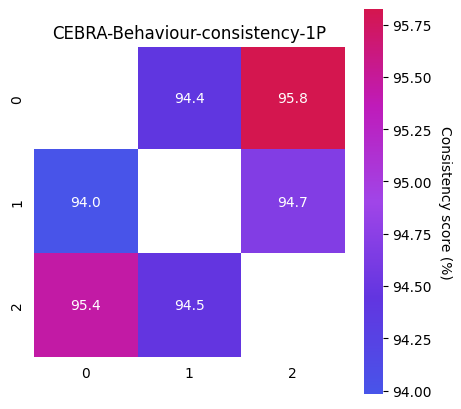

In [23]:
%matplotlib inline
ax = cebra_plot.plot_consistency(scores,
                                 pairs=pairs,
                                 datasets=runs,
                                 title="CEBRA-Behaviour-consistency-1P", cmap='cebra')

Great job! You are now master of CEBRA and DeepLabCut:)